Implemented the following defense mechanisms:
1. Differential Privacy
2. Adversarial Training
3. Feature Suppression

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of X_test: (1016, 32)
Shape of predicted_probabilities: (1016, 3)
Shape of X_inversion (Final Input to Inversion Model): (1016, 35)
Shape of sensitive_test (Labels for Inversion Model): (1016, 2)
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4945 - loss: 0.7101
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6440 - loss: 0.6226
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 0.6060
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6349 - loss: 0.6133
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6838 - loss: 0.5690
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.5391
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6804 - loss: 0.5426
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.5459
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7144 - loss: 0.5458
Epo

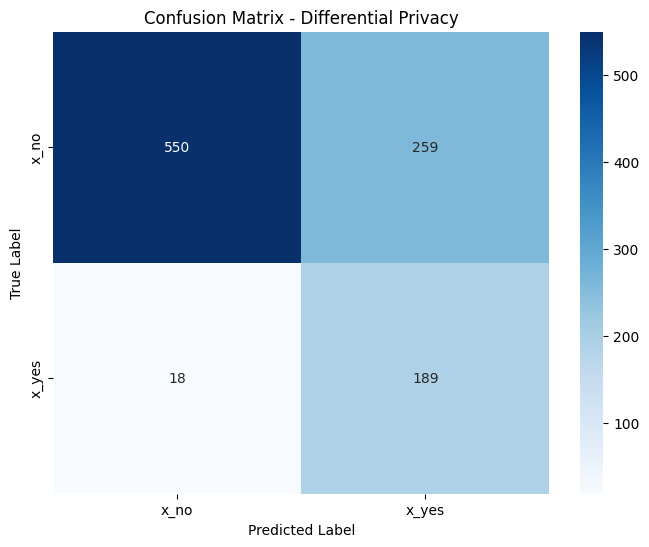


Defense Mechanism: Adversarial Training
Inversion Model Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.72      0.82       809
       x_yes       0.44      0.89      0.59       207

    accuracy                           0.75      1016
   macro avg       0.70      0.80      0.71      1016
weighted avg       0.86      0.75      0.77      1016



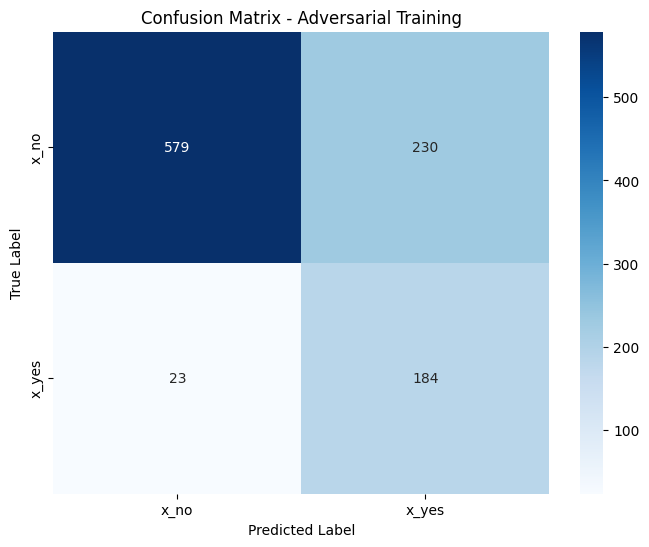


Defense Mechanism: Feature Suppression
Inversion Model Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.70      0.81       809
       x_yes       0.43      0.89      0.58       207

    accuracy                           0.74      1016
   macro avg       0.69      0.79      0.69      1016
weighted avg       0.85      0.74      0.76      1016



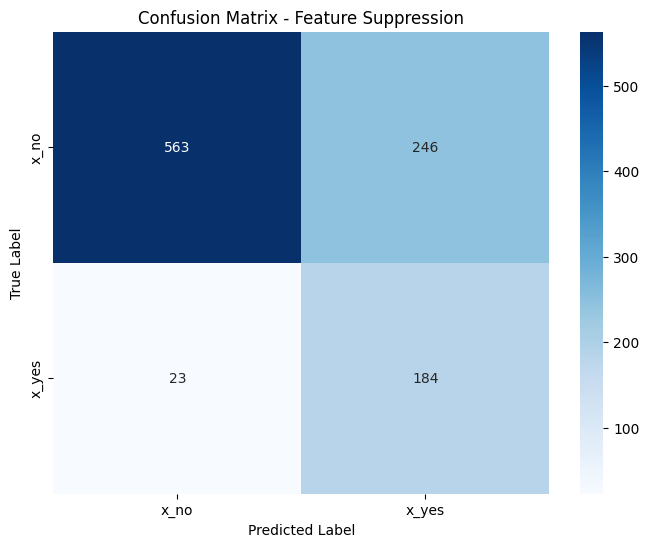

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=1.0):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    # Debugging prints
    print("Using X_inversion for evaluation")
    print("Shape of X_inversion:", X_inversion.shape)

    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

def display_results(results):
    for defense, (accuracy, conf_matrix, class_report) in results.items():
        print(f"\nDefense Mechanism: {defense}")
        print(f"Inversion Model Accuracy: {accuracy:.2f}")
        print("Classification Report:\n", class_report)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {defense}")
        plt.show()

# Train inversion models
inversion_model_dp = train_inversion_model(target_model_dp, X_test, sensitive_test)
inversion_model_adv = train_inversion_model(target_model_adv, X_test, sensitive_test)
inversion_model_suppressed = train_inversion_model(target_model_suppressed, X_test, sensitive_test)

# Evaluate results
results = {
    "Differential Privacy": evaluate_inversion_model(inversion_model_dp, X_test, sensitive_test, target_model_dp),
    "Adversarial Training": evaluate_inversion_model(inversion_model_adv, X_test, sensitive_test, target_model_adv),
    "Feature Suppression": evaluate_inversion_model(inversion_model_suppressed, X_test, sensitive_test, target_model_suppressed)
}

# Display results
display_results(results)
